# Image Captioning

In [117]:
import os
import glob
import cv2
import numpy as np 
import torch
import json 
import h5py
import torch.nn as nn
import torchvision
from tqdm import tqdm 
from collections import Counter
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import transforms as T
from torch.nn.utils.rnn import pack_padded_sequence
import matplotlib.pyplot as plt 
from random import seed,choice,sample

In [118]:
_MAX_LEN=36
device=torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

# Checkpoint

In [119]:
def save_checkpoint(epoch,encoder,decoder,decoder_optimizer):
    state={"epoch":epoch,
           "encoder":encoder,
           "decoder":decoder,
           "decoder_optimizer":decoder_optimizer,}
    filename=f"checkpoint_{str(epoch)}.pth"
    torch.save(state,filename)

# Average meter for loss or accuracy

In [120]:
class average_meter:
    def __init__(self):
        self.value=0
        self.average=0
        self.count=0
        self.sum=0
    def update(self,value,no_samples=1):
        self.value=value
        self.sum+= value * no_samples
        self.count+= no_samples
        self.average=self.sum/self.count

# Accuracy

In [121]:
def _Accuracy(scores,targets,k=3):
    #scores -> bs,max(decoding_len),vocab size --> (sum(Decoding len),vocab size)
    #target -> bs,max(decoding_len) --> (sum(Decoding len)
    batch_size=targets.size(0)
    _,ind=scores.topk(k,1)
    correct=ind.eq(targets.view(-1,1).expand_as(ind)) # since target is of diff shape we are doing view and expand as k
    correct_total=correct.view(-1).float().sum()
    return correct_total*(100.0/batch_size)
    
   

In [122]:
# scores=torch.randn(6,7)
# _,ind=scores.topk(3,1)
# ind.shape

In [123]:
# target=torch.randn(6)
# target.view(-1,1).expand_as(ind).shape

# Learning rate adjustment

In [124]:
def lr_adjustment(optimizer,decay_factor):
    optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*decay_factor
    print(f"the new adjusted lr is : {optimizer.param_groups[0]['lr']:.3f}")

# Dataset

In [125]:
img_dir=r'/mnt/disk1/Gulshan/rnn/image captioning/Images'
caption_dir=r'/mnt/disk1/Gulshan/rnn/image captioning/captions.json'
caption_len_dir=r'/mnt/disk1/Gulshan/rnn/image captioning/captions_len.json'

In [126]:
# with open(caption_dir,'r') as f:
#             captions=json.load(f)
# with open(caption_len_dir,'r') as f:
#     captions_len=json.load(f)
# i=2993
# print(i//5)
# img=glob.glob(f'{img_dir}/*.jpg')
# print(img[i])
# print(captions[i])
# print(captions_len[i])
# image= (Image.open(img[i//5]).convert("RGB"))
# plt.imshow(np.asarray(image))


In [127]:
train_transform = T.Compose([
            # transforms.ToPILImage(),
            T.Resize(size=(254,254)),
            # transforms.RandomHorizontalFlip(0.3),
            T.ToTensor(),
            # normalize,
            T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

In [128]:
class flickr8kdataset(Dataset):
    def __init__(self,img_dir,caption_dir,caption_len_dir,transforms=None) -> None:
        self.img=glob.glob(f'{img_dir}/*.jpg')
        self.captions_per_img=5
        with open(caption_dir,'r') as f:
            self.captions=json.load(f)
        with open(caption_len_dir,'r') as f:
            self.captions_len=json.load(f)
        self.transforms=transforms
        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, index):
        # print(index)
        image= (Image.open(self.img[(index//self.captions_per_img)]).convert("RGB"))
        # plt.imshow(np.asarray(image))
        if self.transforms is not None:
            image=self.transforms(image)
        caption=torch.LongTensor(self.captions[index])
        caption_len=torch.LongTensor([self.captions_len[index]])
        # print("caption len",caption_len)
        # print("caption",caption)
        return (image,caption,caption_len)

In [129]:
# train_loader=torch.utils.data.DataLoader(flickr8kdataset(img_dir,caption_dir,caption_len_dir,train_transform),
#                                          batch_size=10,
#                                          shuffle=True,
#                                          pin_memory=True)

In [130]:

# img,caption,caption_len=next(iter(train_loader))
# print(img.shape,caption.shape,caption_len.shape)

# Encoder 

In [131]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super(Encoder,self).__init__()
        resnet=torchvision.models.resnet101(pretrained=True)
        all_modules=list(resnet.children())
        modules=all_modules[:-2]
        self.resnet=nn.Sequential(*modules)
        self.avgpool=nn.AvgPool2d(8) # at the final you will have 8 feature map
        self.fine_tune()
    def fine_tune(self,fine_tune_=False):
        for param in self.resnet.parameters():
            param.requires_grad= fine_tune_ # freezing the resent trainable parameters(weights) to freeze
    
    def forward(self,img):
        # img -shape (batch size,chaneel ,h,w)
        #img shape(10,3,254,254)
        batch_size=img.shape[0]
        encoded_img=self.resnet(img)
        # print(encoded_img.shape) #torch.Size([10, 2048, 8, 8])
        last_layer=self.avgpool(encoded_img)# (batch_size,2048,1,1) # taking last layer of resnet
        # print(last_layer.shape) -> torch.Size([10, 2048, 1, 1])
        last_layer=last_layer.view(batch_size,-1)
        # print(last_layer.shape) #-> torch.Size([10, 2048])
        return last_layer

In [132]:
# ## understaning
# resent=torchvision.models.resnet101(pretrained=True)
# ex=list(resent.children())
# print(ex[-3])
# ex[-2:] # removing last tow Apa.. and linear..


# Decoder

In [133]:
class Decoder(nn.Module):
    def __init__(self,embed_size,decoder_dim,vocab_size,encoder_dim=2048) -> None:
        super(Decoder,self).__init__()
        self.embed_size=embed_size
        self.decoder_dim=decoder_dim
        self.vocab_size=vocab_size
        self.encoder_dim=encoder_dim
        
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.lstm= nn.LSTMCell(embed_size+encoder_dim,decoder_dim) 
        self.fc= nn.Linear(decoder_dim,vocab_size)
        self.init_weights() # not complusory just to converge faster
        
    def init_weights(self): # not complusory just to converge faster
        # intia;ize for both embedding and fc
        # _ means inplace operation
        self.embedding.weight.data.uniform_(-0.1,0.1)
        self.fc.weight.data.uniform_(-0.1,0.1)
        self.fc.bias.data.fill_(0)
        
    def init_hiddenn_states(self,batch_size):
        h=torch.zeros(batch_size,self.decoder_dim).to(device)
        c=torch.zeros(batch_size,self.decoder_dim).to(device)
        return h,c
    def forward(self,image,encode_captions,cap_len):
        batch_size=image.size(0)
        encoder=image.size(-1)
        cap_len,sorted_idx=cap_len.squeeze(1).sort(dim=0,descending=True)  #org bs : (batch size,1) -> (batch size)
        image=image[sorted_idx]
        encode_captions=encode_captions[sorted_idx]# (bs,max len)
        embeddings=self.embedding(encode_captions)#-> (bs,max len,embed_dim)
        h,c=self.init_hiddenn_states(batch_size)
        
        decode_len=(cap_len-1).tolist()
        predictions=torch.zeros(batch_size,max(decode_len),self.vocab_size).to(device)
        
        for timestep in range(max(decode_len)):
            batch_size_t=sum([l>timestep for l in decode_len])
            lstm_input=torch.cat([embeddings[:batch_size_t,timestep,:],image[:batch_size_t]],dim=-1)
            h,c=self.lstm(lstm_input,(h[:batch_size_t],c[:batch_size_t]))
            predict=self.fc(h)
            predictions[:batch_size_t,timestep,:]=predict
        
        return predictions,encode_captions,decode_len,sorted_idx

In [144]:
embed_size,hidd_size,vocab_size=512,512,len(vocab['word2idx'])
decoder=Decoder(embed_size,hidd_size,vocab_size)
x=torch.randn(1,3,254,254)
cap=torch.randn(1,36)
cap_len=torch.randn(6)
decoder(x,cap,cap_len)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

# uniform_(-0.1,0.1)
# 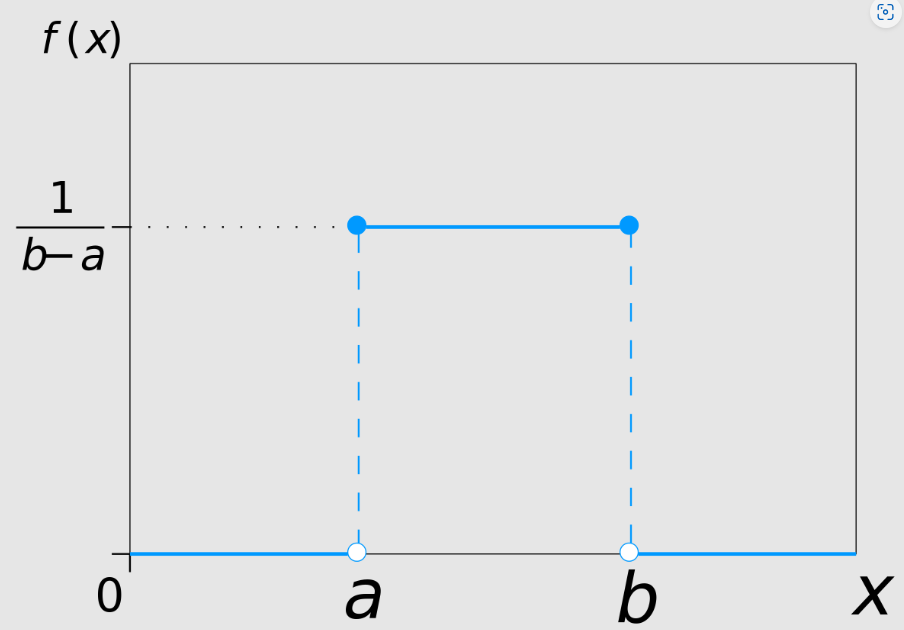

In [ ]:
# decode_len=[8,4,4,3,2]
# for t in range(max(decode_len)):
#     print([l>t for l in decode_len])
#     print(sum([l>t for l in decode_len]))

# TRAIN FUNC

In [ ]:
def train(train_loader,encoder,decoder,criteron,decoder_optimizer,epoch,freq):
    encoder.train()
    decoder.train()
    
    losses=average_meter()
    top_3_accuracy=average_meter()
    
    for i,(img,cap,cap_len) in enumerate(train_loader):
        img=img.to(device)
        cap=cap.to(device)
        cap_len=cap_len.to(device)
        encoeder_features=encoder(img)
        scores,cap_sorted,decode_len,sorted_idx=decoder(encoeder_features,cap,cap_len)
        target=cap_sorted[:,1:]
        scores=pack_padded_sequence(scores,decode_len,batch_first=True)
        target=pack_padded_sequence(target,decode_len,batch_first=True)
        loss=criteron(scores.data,target.data)
        
        decoder_optimizer.zero_grad()
        loss.backward()
        
        decoder_optimizer.step()
        
        top3=_Accuracy(scores.data,target.data,k=3)
        
        
        losses.update(loss.item(),sum(decode_len))
        top_3_accuracy.update(top3,sum(decode_len))
        
        if i%freq==0:
            print("Epoch :[{0}] [{1}/{2}]\t"
                  "loss {loss.value:.4f} ({loss.average:.4f})\t"
                  "top 3 ACCURACY : {top3.value:.3f} ({top3.average:.3f})".format(epoch,i,len(train_loader),
                                                                            loss=losses,top3=top_3_accuracy))
        
        

# HYPER PARAMETERS

In [ ]:
embed_dim=512
hidden_dim=512
decoder_lr= 2e-5
start_epoch=0
epochs=10
bs=32
freq=100
with open("/mnt/disk1/Gulshan/rnn/image captioning/wordmap_flick8k.json",'r') as f:
            vocab=json.load(f)
#print(len(vocab['word2idx']))
checkpoint="/mnt/disk1/Gulshan/rnn/image captioning/checkpoint_6.pth"
checkpoint=None
if checkpoint:
    checkpoint=torch.load(checkpoint)
    start_epoch=checkpoint['epoch']+1
    decoder=checkpoint['decoder']
    encoder=checkpoint['encoder']
    decoder_optimizer=checkpoint['decoder_optimizer']
else:
    encoder=Encoder()
    decoder=Decoder(embed_size=embed_dim,decoder_dim=hidden_dim,vocab_size=len(vocab['word2idx']))
    decoder_optimizer=torch.optim.Adam(decoder.parameters(),lr=decoder_lr)

encoder=encoder.to(device)
decoder=decoder.to(device)
criterion=nn.CrossEntropyLoss().to(device)
train_loader=torch.utils.data.DataLoader(flickr8kdataset(img_dir,caption_dir,caption_len_dir,train_transform),
batch_size=bs, shuffle=True, pin_memory=True)

In [ ]:
for epoch in range(start_epoch,epochs):
    if epoch%3==0 and epoch!=0:
        lr_adjustment(decoder_optimizer,0.8)
    train(train_loader=train_loader,encoder=encoder,decoder=decoder
          ,criteron=criterion,decoder_optimizer=decoder_optimizer,
          epoch=epoch,freq=5)
    # save_checkpoint(epoch,encoder,decoder,decoder_optimizer)

Epoch :[0] [0/253]	loss 9.2875 (9.2875)	top 3 ACCURACY : 0.000 (0.000)
Epoch :[0] [5/253]	loss 9.1313 (9.2210)	top 3 ACCURACY : 0.252 (0.042)
Epoch :[0] [10/253]	loss 8.9699 (9.1338)	top 3 ACCURACY : 6.538 (1.573)
Epoch :[0] [15/253]	loss 8.8172 (9.0513)	top 3 ACCURACY : 16.062 (5.196)
Epoch :[0] [20/253]	loss 8.6146 (8.9638)	top 3 ACCURACY : 22.651 (9.162)
Epoch :[0] [25/253]	loss 8.4999 (8.8758)	top 3 ACCURACY : 21.106 (11.818)
Epoch :[0] [30/253]	loss 8.3366 (8.7952)	top 3 ACCURACY : 21.622 (13.522)
Epoch :[0] [35/253]	loss 8.0452 (8.7073)	top 3 ACCURACY : 22.922 (14.838)
Epoch :[0] [40/253]	loss 7.8877 (8.6217)	top 3 ACCURACY : 24.860 (15.823)
Epoch :[0] [45/253]	loss 7.7824 (8.5359)	top 3 ACCURACY : 21.340 (16.520)
Epoch :[0] [50/253]	loss 7.4911 (8.4439)	top 3 ACCURACY : 25.258 (17.228)
Epoch :[0] [55/253]	loss 7.4133 (8.3547)	top 3 ACCURACY : 22.811 (17.753)
Epoch :[0] [60/253]	loss 7.2694 (8.2714)	top 3 ACCURACY : 22.111 (18.198)
Epoch :[0] [65/253]	loss 7.1836 (8.1987)	top 3 A

KeyboardInterrupt: 

In [ ]:
vocab['word2idx']['<START>']
vocab['idx2word']['0']

'PAD'

In [ ]:
def greedy_decode(image):
    decoder.eval()
    encoder.eval()
    samples=[]
    # rev 
    image= (Image.open(image).convert("RGB"))
    plt.imshow(np.asarray(image))
    image=train_transform(image).to(device)
    # caption=torch.LongTensor(self.captions[index])
    # caption_len=torch.LongTensor([self.captions_len[index]])
    image=image.unsqueeze(0)
    # print(image.shape)#-> torch.Size([1, 3, 254, 254])
    encoder_features=encoder(image).to(device)
    pred=torch.LongTensor([[vocab['word2idx']['<START>']]]).to(device) #(1,1)
    h,c=decoder.init_hiddenn_states(1)
    
    for timestep in range(20):
        embedding=decoder.embedding(pred).squeeze(1) #(1,1,512) -> (1,512)
        lstm_input=torch.cat([embedding,encoder_features],dim=-1) #(1,512) + (1,512)->(1024)
        h,c=decoder.lstm(lstm_input,(h,c))
        predict=decoder.fc(h) #(1,vocabs-ze)
        _,idx=predict.max(1)
        samples.append(idx.item())
        if idx==vocab['word2idx']['<END>']:
            break
    # print(samples)
    generated_words=[vocab['idx2word'][str(samples[i])] for i in range(len(samples))]
    filtered_word=" ".join([word for word in generated_words])
    print(filtered_word)
    

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:7! (when checking argument for argument index in method wrapper_CUDA__index_select)

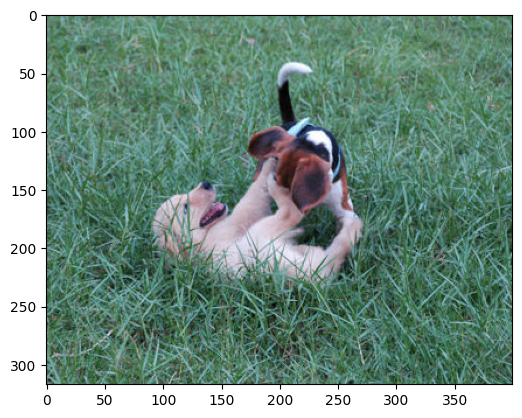

In [139]:
greedy_decode(r'/mnt/disk1/Gulshan/rnn/image captioning/Images/23445819_3a458716c1.jpg')